#**Вариант 5, регрессия**

Датасет: https://drive.google.com/file/d/1yVjIgA7DMuHzxEQgTpV_slBAcmUYVPWI/view?usp=sharing

# **Импорт и предобработка**

## Загрузка и описание

**Описание полей**

Задача прогнозирования цены искусственных бриллиантов. Описание полей

•	num - номер  
•	carat - вес в каратах  
•	cut - качество огранки  
•	color - код цвета  
•	clarity - код прозрачности  
•	depth - прорции глубины (отношение глубины к среднему значению ширины/высоты в %)  
•	table - пропорции (отношение ширины к высоте в %)
price - цена (целевое поле)  
•	x - ширина  
•	y - высота  
•	z - глубина  


In [119]:
import numpy as np
import pandas as pd

data = pd.read_csv('5_data.csv')
print(data.shape)
data.head()

(3000, 11)


,num,carat,cut,color,clarity,depth,table,price,x,y,z
0,10843,1.06,Premium,H,SI1,61.6,59.0,4872,6.55,6.54,4.03
1,49651,0.70,Premium,F,SI2,59.6,60.0,2139,5.77,5.71,3.42
2,7300,1.00,Premium,E,SI2,58.5,61.0,4202,6.52,6.48,3.80
3,36593,0.45,Very Good,I,VVS1,63.0,56.0,947,4.88,4.90,3.08
4,37447,0.50,Very Good,H,SI1,63.1,55.0,984,5.09,5.02,3.19


## Drop признаков

Я считаю, что можно убрать признак num, так как он не может являться значимым. Это просто еще один идентификатор.

In [120]:
data.drop(columns=['num'], inplace = True)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Premium,H,SI1,61.6,59.0,4872,6.55,6.54,4.03
1,0.70,Premium,F,SI2,59.6,60.0,2139,5.77,5.71,3.42
2,1.00,Premium,E,SI2,58.5,61.0,4202,6.52,6.48,3.80
3,0.45,Very Good,I,VVS1,63.0,56.0,947,4.88,4.90,3.08
4,0.50,Very Good,H,SI1,63.1,55.0,984,5.09,5.02,3.19


## Работа с типами данных

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    3000 non-null   float64
 1   cut      3000 non-null   object 
 2   color    3000 non-null   object 
 3   clarity  3000 non-null   object 
 4   depth    3000 non-null   float64
 5   table    3000 non-null   float64
 6   price    3000 non-null   int64  
 7   x        3000 non-null   float64
 8   y        3000 non-null   float64
 9   z        3000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 234.5+ KB


Нечего конвертировать, данные в порядке.

## Работа с дубликатами

In [122]:
data.duplicated().sum()

np.int64(0)

Дубликатов нет.

## Работа с пропусками

In [123]:
data.isnull().sum()

,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


Пропусков нет.

## Работа с выбросами

Вспомним числовые поля.

In [124]:
print(data.dtypes)

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


Построим гистограмы для всех числовых полей (их немного)

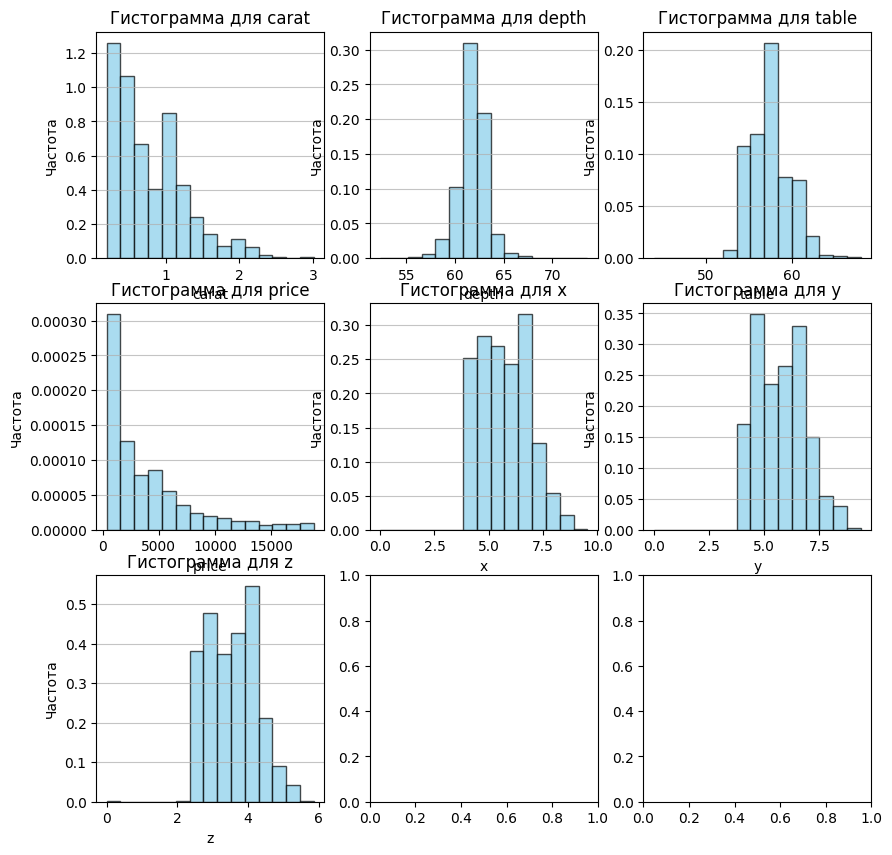

In [125]:
import matplotlib.pyplot as plt

numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, column in enumerate(numeric_columns):
    ax = axs[i // 3, i % 3]
    ax.hist(data[column], bins=15, alpha=0.7, color='skyblue', edgecolor='black', density=True)

    ax.set_title(f'Гистограмма для {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Частота')
    ax.grid(axis='y', alpha=0.75)
plt.show()

Уже сейчас видно, что особых выбросов нет.

Проверим это при помощи ящиков с усами boxplots

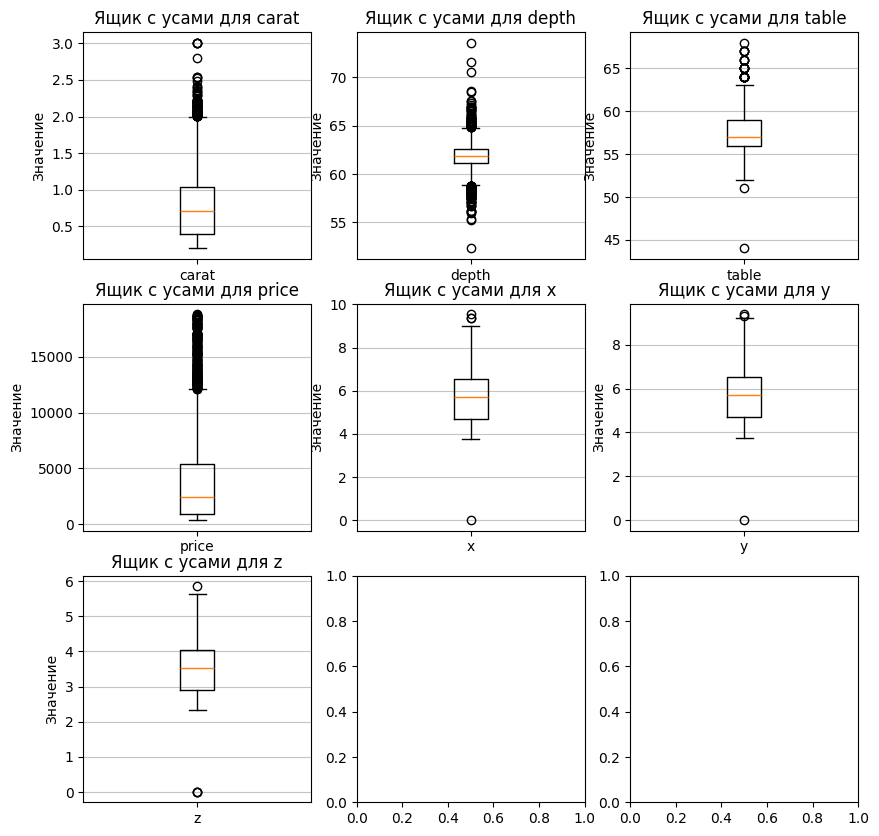

In [126]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, column in enumerate(numeric_columns):
    ax = axs[i // 3, i % 3]
    ax.boxplot(data[column])

    ax.set_title(f'Ящик с усами для {column}')
    ax.set_ylabel('Значение')
    ax.set_xticks([1])
    ax.set_xticklabels([column])
    ax.grid(axis='y', alpha=0.75)
plt.show()

В моем понимании выбросы достаточно незначительны и скорее всего не сильно повлияют на модель, но я все равно воспользуюсь стандартным способом через квантили:

In [127]:
for i, column in enumerate(numeric_columns):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  data[(data[column] < lower) | (data[column] > upper)]
  data = data[(data[column] >= lower) & (data[column] <= upper)]

Проверим результат.

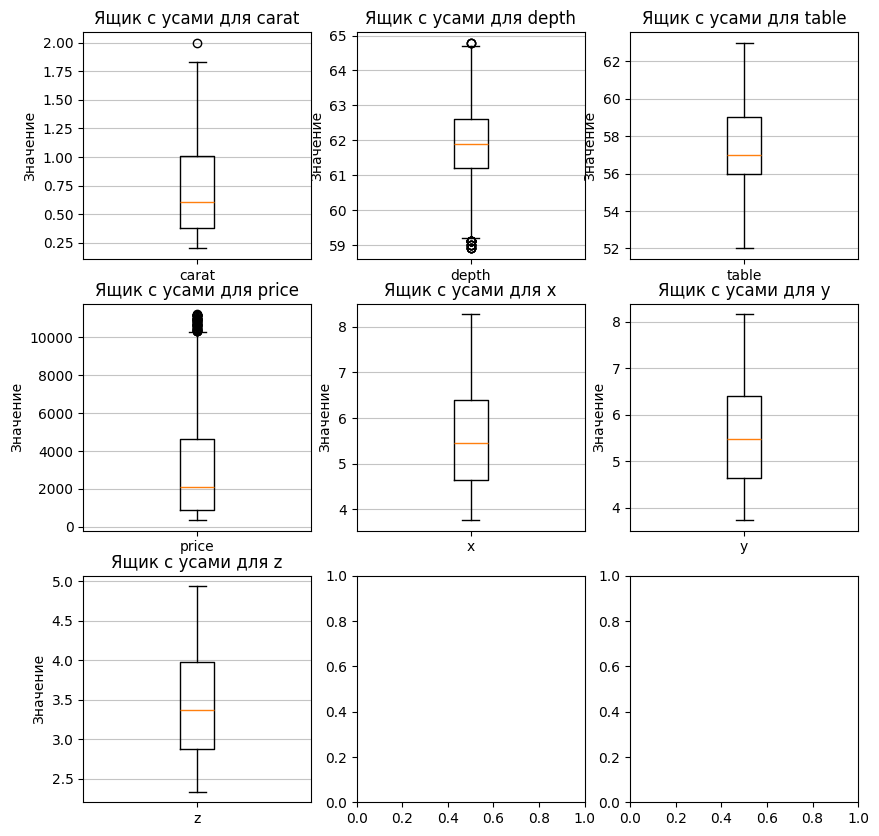

In [128]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, column in enumerate(numeric_columns):
    ax = axs[i // 3, i % 3]
    ax.boxplot(data[column])

    ax.set_title(f'Ящик с усами для {column}')
    ax.set_ylabel('Значение')
    ax.set_xticks([1])
    ax.set_xticklabels([column])
    ax.grid(axis='y', alpha=0.75)
plt.show()

## Кодирование категориальных

In [129]:
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.06,61.6,59.0,4872,6.55,6.54,4.03,False,False,True,...,True,False,False,False,True,False,False,False,False,False
1,0.70,59.6,60.0,2139,5.77,5.71,3.42,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,0.45,63.0,56.0,947,4.88,4.90,3.08,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,0.50,63.1,55.0,984,5.09,5.02,3.19,False,False,False,...,True,False,False,False,True,False,False,False,False,False
5,0.32,62.1,54.0,393,4.38,4.44,2.74,False,True,False,...,False,False,True,False,False,False,False,True,False,False


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2608 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          2608 non-null   float64
 1   depth          2608 non-null   float64
 2   table          2608 non-null   float64
 3   price          2608 non-null   int64  
 4   x              2608 non-null   float64
 5   y              2608 non-null   float64
 6   z              2608 non-null   float64
 7   cut_Good       2608 non-null   bool   
 8   cut_Ideal      2608 non-null   bool   
 9   cut_Premium    2608 non-null   bool   
 10  cut_Very Good  2608 non-null   bool   
 11  color_E        2608 non-null   bool   
 12  color_F        2608 non-null   bool   
 13  color_G        2608 non-null   bool   
 14  color_H        2608 non-null   bool   
 15  color_I        2608 non-null   bool   
 16  color_J        2608 non-null   bool   
 17  clarity_IF     2608 non-null   bool   
 18  clarity_SI1  

Посмотрели, сколько dummy-признаков создалось.

## Формирование обучающего и тестового множества

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
X = data.drop('price', axis=1)
y = data['price']
x_learn, x_test, y_learn, y_test = train_test_split(X, y, test_size=0.2)

## Скейлинг

In [133]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
x_learn_scaled = scaler.fit_transform(x_learn)
x_test_scaled = scaler.transform(x_test)

# scaler_y = MinMaxScaler()
# y_learn_scaled = scaler_y.fit_transform(y_learn.values.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# y_learn_scaled = y_learn_scaled.ravel()
# y_test_scaled = y_test_scaled.ravel()

## Выбор метрик

In [134]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

Итак,
1.   MAE (Mean Absolute Error)
*   выражается в тех же единицах, что и целевая переменная и легко интерпретируется: MAE=200000 означает "модель ошибается на +-200 000 рублей"
*   не штрафует за большие ошибки
2.   RMSE (Root Mean Squared Error)
*   показывает насколько хорошо модель предсказывает вариативность данных
*   чувствительна к выбросам и сильно штрафует за большие ошибки (квадрат), в задаче

В целом, эти две метрики дополняют друг друга и являются базовыми. Если модель плохо работает с большими ценами - RMSE покажет это, а в целом можно смотреть на MAE.

Также, я бы хотел использовать R2 (коэф детерминации) и MAPE (Mean Absolute Percentage Error).
3.   R2 показывает, насколько модель лучше константного прогноза (среднего значения).
4.   MAPE, из того что я понял, является хорошим выбором, так как показывает относительные ошибки. Ошибиться на 500 тысяч для квартиры в 10 миллионов еще как приемлемо, но вот для квартиры за полтора - не очень.

## Итог

In [135]:
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.06,61.6,59.0,4872,6.55,6.54,4.03,False,False,True,...,True,False,False,False,True,False,False,False,False,False
1,0.70,59.6,60.0,2139,5.77,5.71,3.42,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,0.45,63.0,56.0,947,4.88,4.90,3.08,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,0.50,63.1,55.0,984,5.09,5.02,3.19,False,False,False,...,True,False,False,False,True,False,False,False,False,False
5,0.32,62.1,54.0,393,4.38,4.44,2.74,False,True,False,...,False,False,True,False,False,False,False,True,False,False


In [136]:
print(f'learn: {x_learn_scaled.shape} - {y_learn.shape}; test: {x_test_scaled.shape} - {y_test.shape}')

learn: (2086, 23) - (2086,); test: (522, 23) - (522,)


In [137]:
print(pd.Series(y).describe())

count     2608.000000
mean      3062.045245
std       2648.251191
min        348.000000
25%        894.750000
50%       2094.000000
75%       4656.250000
max      11216.000000
Name: price, dtype: float64


# **Функции** для обучения и построения графиков

Взял эти функции из коллаба для своей контрольной, чтобы долго не писать их

In [139]:
def training_yscaling():
  model.fit(x_learn_scaled, y_learn_scaled)

  y_pred_learn_scaled = model.predict(x_learn_scaled)
  y_pred_test_scaled = model.predict(x_test_scaled)

  y_learn_unscaled = scaler_y.inverse_transform(y_learn_scaled.reshape(-1, 1))
  y_test_unscaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
  y_pred_learn_unscaled = scaler_y.inverse_transform(y_pred_learn_scaled.reshape(-1, 1))
  y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1))

  results(y_learn_unscaled, y_test_unscaled, y_pred_learn_unscaled, y_pred_test_unscaled)


def training(model_name, retrn_model = False, prnt=True):
  model = model_name
  model.fit(x_learn_scaled, y_learn)

  y_pred_learn = model.predict(x_learn_scaled)
  y_pred_test = model.predict(x_test_scaled)

  if retrn_model:
    return model
  if prnt:
    results(y_learn, y_test, y_pred_learn, y_pred_test)


# какие-то версии разные с семинаров еще

def results(yl, yt, ypl, ypt, prnt = True, retrn = False, graph = True):
  mae_learn = mean_absolute_error(yl, ypl)
  mae_test = mean_absolute_error(yt, ypt)
  rmse_learn = root_mean_squared_error(yl, ypl)
  rmse_test = root_mean_squared_error(yt, ypt)
  mape_learn = mean_absolute_percentage_error(yl, ypl)
  mape_test = mean_absolute_percentage_error(yt, ypt)
  r2_learn = r2_score(yl, ypl)
  r2_test = r2_score(yt, ypt)

  if prnt:
    print(f'Learn: r2 = {r2_learn:.4f}; MAE = {mae_learn:.0f}; RMSE = {rmse_learn:.0f}; MAPE: {mape_learn:.4f}')
    print(f'Test: r2 = {r2_test:.4f}; MAE = {mae_test:.0f}; RMSE = {rmse_test:.0f}; MAPE: {mape_test:.4f}')


  if graph:
    plt.figure(figsize=(6, 6))
    plt.scatter(yl, ypl, label='Обучающая выборка', alpha=0.8, s=15)
    plt.scatter(yt, ypt,  label='Тестовая выборка', alpha=0.8, s=15)

    p1 = min(min(ypl), min(ypt))
    p2 = max(max(ypl), max(ypt))
    plt.plot([p1, p2],[p1, p2],color='red', linestyle='-', label='Идеальное предсказание (y = x)')

    plt.title('Результаты моделирования')
    plt.legend()
    plt.grid()
    plt.xlabel('Реальные значения')
    plt.ylabel('Прогнозные значения')
    plt.show()

  if retrn:
    return r2_test

def results_old(prnt = True, retrn = False, graph = True):
  mae_learn = mean_absolute_error(y_learn, y_pred_learn)
  mae_test = mean_absolute_error(y_test, y_pred_test)
  rmse_learn = root_mean_squared_error(y_learn, y_pred_learn)
  rmse_test = root_mean_squared_error(y_test, y_pred_test)
  mape_learn = mean_absolute_percentage_error(y_learn, y_pred_learn)
  mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
  r2_learn = r2_score(y_learn, y_pred_learn)
  r2_test = r2_score(y_test, y_pred_test)

  if prnt:
    print(f'Learn: r2 = {r2_learn:.4f}; MAE = {mae_learn:.0f}; RMSE = {rmse_learn:.0f}; MAPE: {mape_learn:.4f}')
    print(f'Test: r2 = {r2_test:.4f}; MAE = {mae_test:.0f}; RMSE = {rmse_test:.0f}; MAPE: {mape_test:.4f}')


  if graph:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_learn, y_pred_learn, label='Обучающая выборка', alpha=0.8, s=15)
    plt.scatter(y_test, y_pred_test,  label='Тестовая выборка', alpha=0.8, s=15)

    p1 = min(min(y_pred_learn), min(y_pred_test))
    p2 = max(max(y_pred_learn), max(y_pred_test))
    plt.plot([p1, p2],[p1, p2],color='red', linestyle='-', label='Идеальное предсказание (y = x)')

    plt.title('Результаты моделирования')
    plt.legend()
    plt.grid()
    plt.xlabel('Реальные значения')
    plt.ylabel('Прогнозные значения')
    plt.show()

  if retrn:
    return r2_test

# **Обучение**: sklearn

## Простые модели

### Linear

Learn: r2 = 0.9305; MAE = 492; RMSE = 706; MAPE: 0.2906
Test: r2 = 0.9273; MAE = 475; RMSE = 676; MAPE: 0.3163


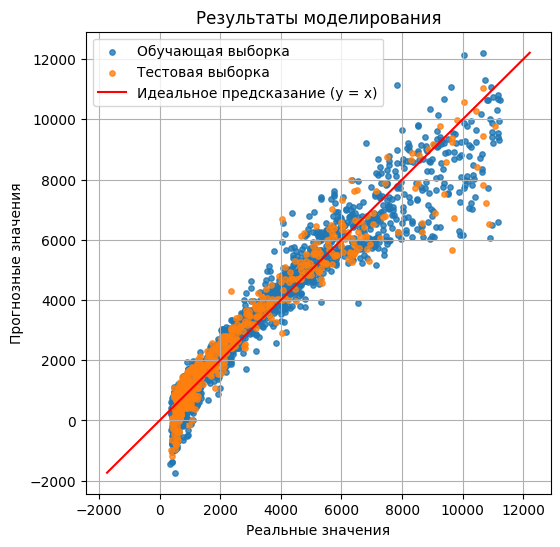

In [140]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
training(model)

### Ridge

In [144]:
from sklearn.linear_model import Ridge

alphas, values = [], []
for i in range(1,100):
  training(Ridge(alpha=i), prnt=False)
  r2_now = results_old(prnt = False, retrn = True, graph=False)
  alphas.append(i)
  values.append(r2_now)

best r2: -1.0970039174524397, alpha = 1


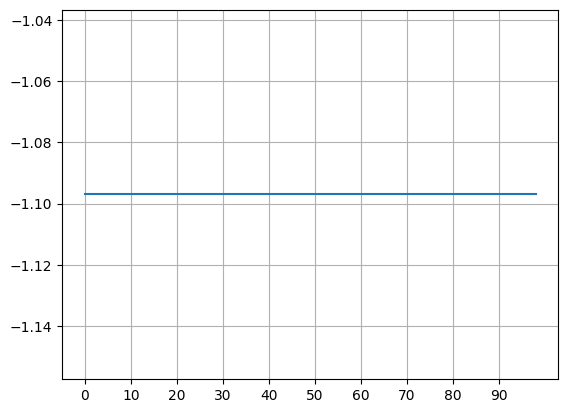

In [145]:
index_max = values.index(max(values))
print(f"best r2: {values[index_max]}, alpha = {alphas[index_max]}")
plt.plot(values)
plt.grid()
plt.xticks(np.arange(0, 100, step=10))
plt.show()

Learn: r2 = 0.9227; MAE = 539; RMSE = 745; MAPE: 0.3225
Test: r2 = 0.9160; MAE = 526; RMSE = 726; MAPE: 0.3461


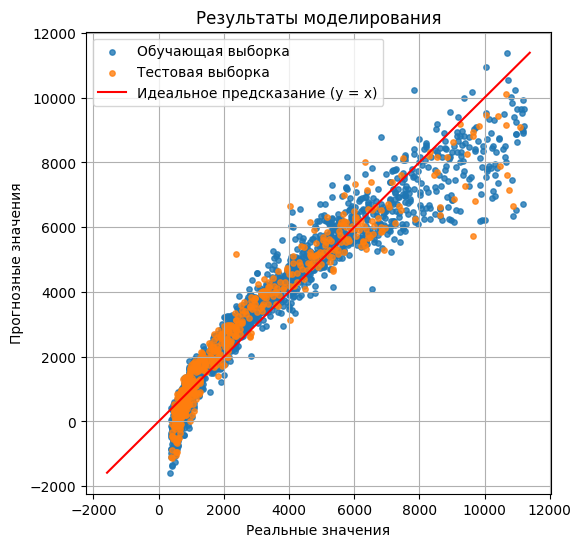

In [147]:
from sklearn.linear_model import Ridge

model=Ridge(alpha=1)
training(model)

## Деревья решений

### DecisionTreeRegressor

Learn: r2 = 0.9856; MAE = 170; RMSE = 321; MAPE: 0.0567
Test: r2 = 0.9113; MAE = 385; RMSE = 747; MAPE: 0.1411


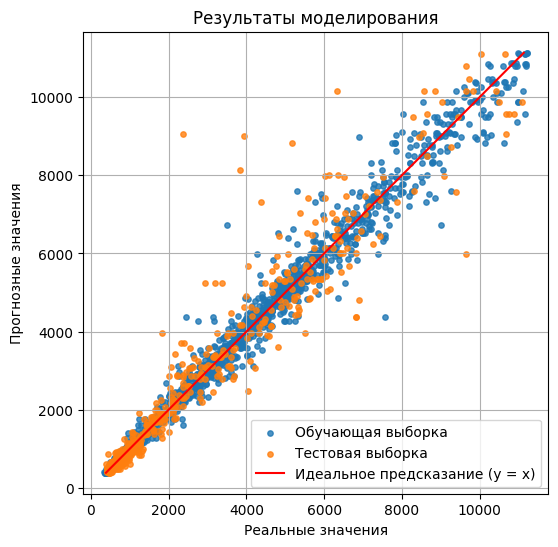

In [150]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=3, min_samples_split=5)
training(model)
ret = training(model, retrn_model=True)

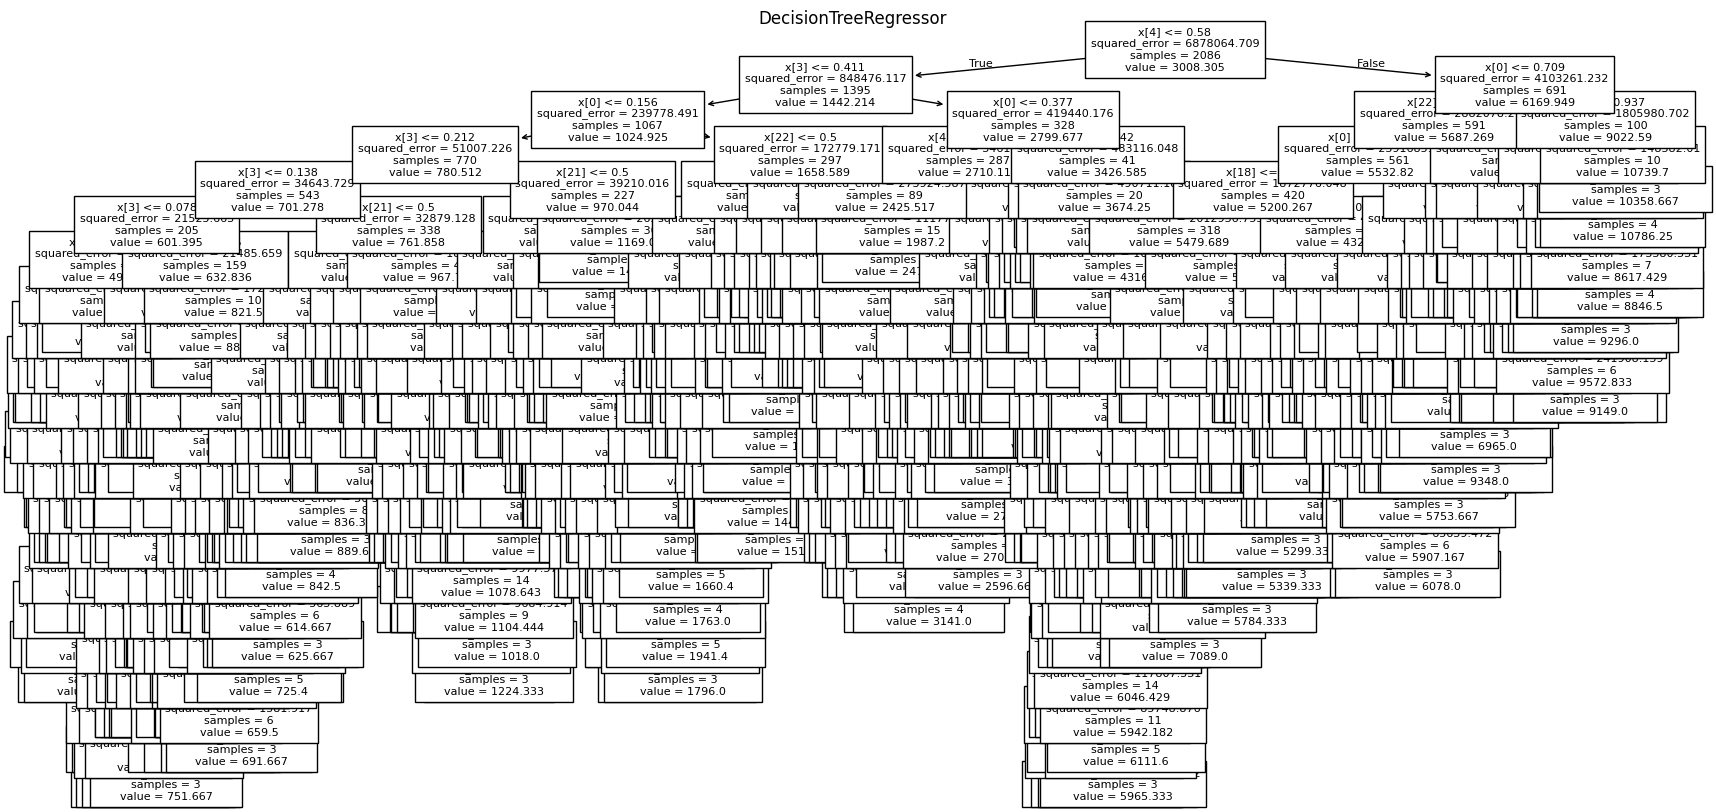

In [97]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(ret,fontsize=8)
plt.title("DecisionTreeRegressor")
plt.show()

### RandomForestRegressor

Learn: r2 = 0.9934; MAE = 120; RMSE = 218; MAPE: 0.0410
Test: r2 = 0.9452; MAE = 295; RMSE = 587; MAPE: 0.1068


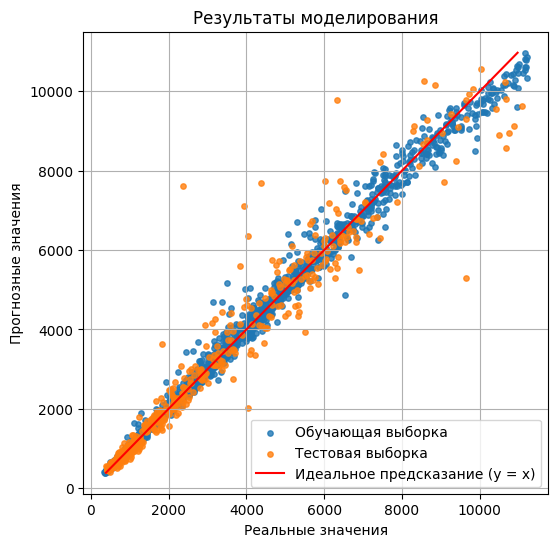

In [152]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators = 100)
training(model)

## Ансамбли

BaggingRegressor

Learn: r2 = 0.9935; MAE = 120; RMSE = 216; MAPE: 0.0407
Test: r2 = 0.9456; MAE = 295; RMSE = 585; MAPE: 0.1070


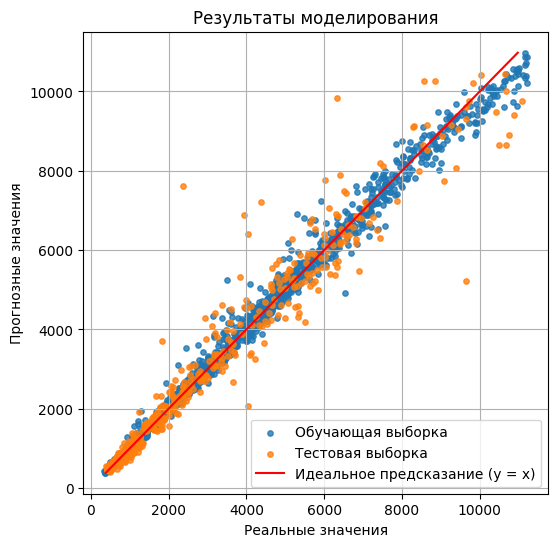

In [154]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(n_estimators = 100)
training(model)

## Нейросетевые модели

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Learn: r2 = 0.9828; MAE = 208; RMSE = 344; MAPE: 0.0814
Test: r2 = 0.9685; MAE = 283; RMSE = 485; MAPE: 0.0930


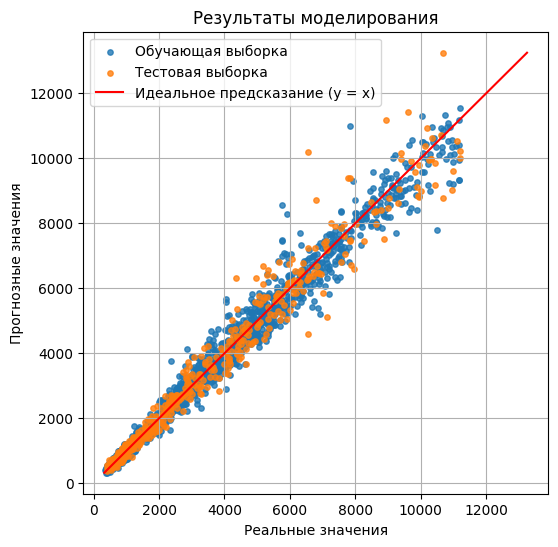

In [100]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes = (100, 100, 100, 100, 100,))
training(model)

# **Обучение**: keras

In [114]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model = Sequential([
  Input(shape=[x_learn_scaled.shape[1]]),
  Dense(256, activation='selu'),
  Dropout(0.08),
  Dense(128, activation='relu'),
  Dropout(0.05),
  Dense(1)
])

callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

model.compile(
    loss='mse',
    optimizer=Adam(),
    metrics=['mae']
)

In [115]:
history = model.fit(
    x_learn_scaled,
    y_learn,
    epochs=100,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 15999744.0000 - mae: 3013.3105 - val_loss: 14992584.0000 - val_mae: 2884.2039
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 14972657.0000 - mae: 2875.8494 - val_loss: 12348398.0000 - val_mae: 2441.1023
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 11450889.0000 - mae: 2318.8630 - val_loss: 7645044.0000 - val_mae: 1864.9658
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7797237.5000 - mae: 1907.1986 - val_loss: 5114370.5000 - val_mae: 1787.0193
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5388460.0000 - mae: 1821.0081 - val_loss: 4656823.5000 - val_mae: 1794.9003
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4430529.0000 - mae: 1722.9614 - val_loss: 4312949.0000 - val_mae: 1729.2932
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4451091.5000 - mae: 1725.0847 - val_loss: 3876963.7500 - val_mae: 1616.9542
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

In [117]:
y_pred = model.predict(x_test_scaled)
print("R2:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R2: 0.9298965930938721
MAPE: 0.2900656759738922


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


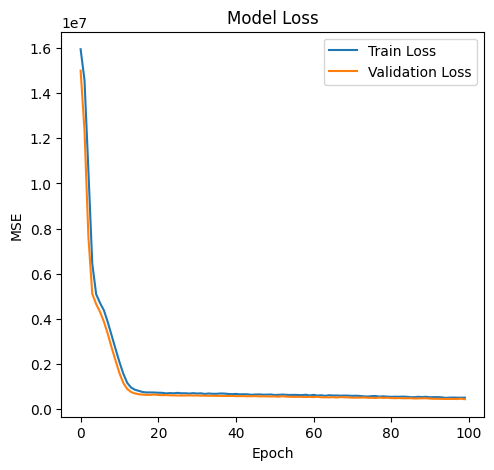

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred = model.predict(x_learn_scaled).flatten()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

# **Выводы**

В отличие от контрольной работы, этот датасет оказался достаточно простым. Даже простые модели по типу LinearRegression смогли выдать достаточно хороший результатов в 91% r2 на тестовом множестве. Однако, естественно, модели посерьезнее справились лучше. Так, MLPRegressor выдал отличные результаты, однако все остальные метрики тоже замечательные. 9% MAPE это круто.

Я не очень много работал с Keras и время поджимало, поэтому модель в Keras получилась явно хуже. Вероятно недообучена. Хотя скорее всего структура плохая.

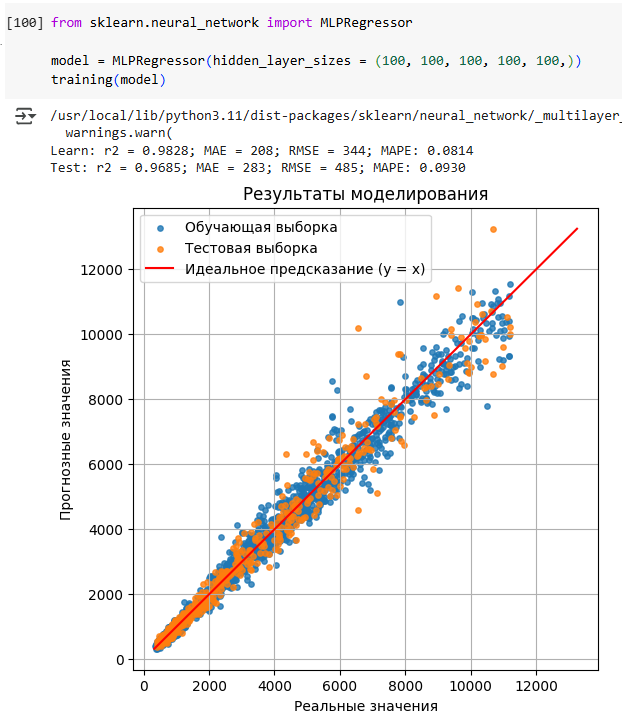

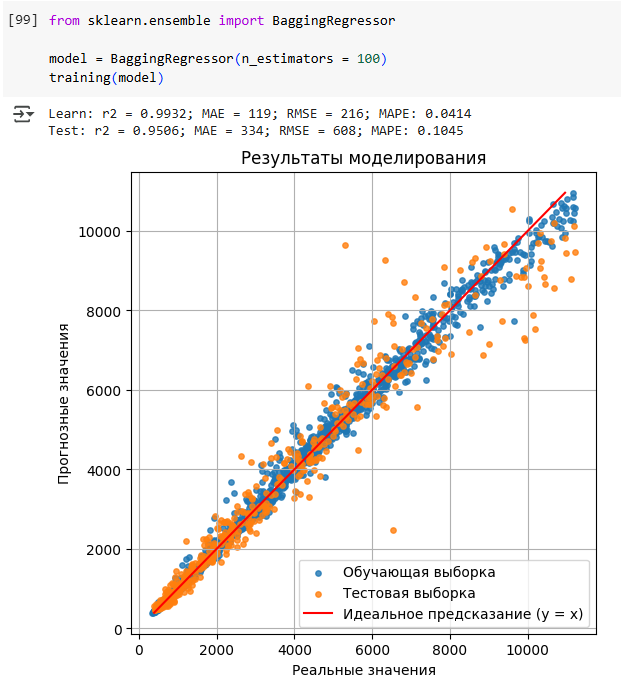